In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score,classification_report, roc_curve
import os
from sklearn.model_selection import  RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import pickle
import shap
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost

# Importação

In [15]:
# 1. Especifique o caminho para a pasta onde seus arquivos CSV estão localizados.
caminho_da_pasta = 'dados/train_test_ohe'

# Cria um dicionário vazio para armazenar os DataFrames
dados = {}

# Lista todos os arquivos na pasta especificada
try:
    lista_de_arquivos = os.listdir(caminho_da_pasta)

    # Itera sobre cada arquivo encontrado na pasta
    for arquivo in lista_de_arquivos:
        # Verifica se o arquivo é um .csv
        if arquivo.endswith('.csv'):
            # Cria o nome da "variável" (que será a chave do dicionário) removendo a extensão .csv
            nome_variavel = os.path.splitext(arquivo)[0]
            
            # Constrói o caminho completo para o arquivo
            caminho_completo = os.path.join(caminho_da_pasta, arquivo)
            
            # Carrega o arquivo CSV e o armazena no dicionário
            dados[nome_variavel] = pd.read_csv(caminho_completo)
            
            print(f"Arquivo '{arquivo}' carregado com sucesso em dados['{nome_variavel}']")

except FileNotFoundError:
    print(f"Erro: O diretório não foi encontrado em '{caminho_da_pasta}'.")
    print("Por favor, verifique se o caminho está correto e tente novamente.")

Arquivo 'X_test_centro_oeste.csv' carregado com sucesso em dados['X_test_centro_oeste']
Arquivo 'X_test_nordeste.csv' carregado com sucesso em dados['X_test_nordeste']
Arquivo 'X_test_norte.csv' carregado com sucesso em dados['X_test_norte']
Arquivo 'X_test_sudeste.csv' carregado com sucesso em dados['X_test_sudeste']
Arquivo 'X_test_sul.csv' carregado com sucesso em dados['X_test_sul']
Arquivo 'X_train_centro_oeste.csv' carregado com sucesso em dados['X_train_centro_oeste']
Arquivo 'X_train_nordeste.csv' carregado com sucesso em dados['X_train_nordeste']
Arquivo 'X_train_norte.csv' carregado com sucesso em dados['X_train_norte']
Arquivo 'X_train_sudeste.csv' carregado com sucesso em dados['X_train_sudeste']
Arquivo 'X_train_sul.csv' carregado com sucesso em dados['X_train_sul']
Arquivo 'y_test_centro_oeste.csv' carregado com sucesso em dados['y_test_centro_oeste']
Arquivo 'y_test_nordeste.csv' carregado com sucesso em dados['y_test_nordeste']
Arquivo 'y_test_norte.csv' carregado com s

# Modelagem Automatizada

In [16]:
# --- PREPARAÇÃO PARA O TREINAMENTO AUTOMATIZADO ---

# 1. Identificar as regiões automaticamente a partir das chaves do dicionário 'dados'
#    Ex: extrair 'sudeste' de 'X_train_sudeste'
regioes = ['nordeste', 'norte', 'centro_oeste', 'sudeste', 'sul']
print(f"Regiões encontradas para o treinamento: {regioes}")

# 2. Definir os modelos e seus grids de hiperparâmetros em um só lugar
#    Isso facilita a manutenção e a adição de novos modelos no futuro.

modelos_a_treinar = {
    'RandomForest': {
        'modelo': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 300, 500],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [2, 4]
        },
        'n_iter': 50 # Número de iterações para o RandomizedSearchCV
    },
    'XGBoost': {
        'modelo': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 500, 1000],
            'max_depth': [3, 6, 9],
            'eta': [0.01, 0.05, 0.1] # 'eta' é o mesmo que 'learning_rate'
        },
        'n_iter': 5
    },
    'LightGBM': {
        'modelo': lgb.LGBMClassifier(random_state=42),
        'params': {
            'bagging_fraction': [0.5, 0.8, 1.0],
            'feature_fraction': [0.5, 0.8, 1.0],
            'num_leaves': [256, 512],
            'min_data_in_leaf': [90, 120]
        },
        'n_iter': 50
    },
    'CatBoost': {
        'modelo': CatBoostClassifier(random_state=42, verbose=0), # verbose=0 para não poluir o output
        'params': {
            "depth": [3, 5, 7, 9, 10],
            "iterations": [250, 500, 1000],
            "learning_rate": [0.01, 0.03, 0.1],
            "l2_leaf_reg": [1, 3, 10],
            "border_count": [32, 50, 100]
        },
        'n_iter': 5
    }
}

# 3. Criar uma lista para guardar os resultados de todos os modelos e regiões
resultados_gerais = []

# Garante que o diretório para salvar os modelos exista
output_dir = "modelos_hiperparametrizados_pos_pandemia"
os.makedirs(output_dir, exist_ok=True)
print(f"Diretório para salvar os modelos: '{output_dir}'")

Regiões encontradas para o treinamento: ['nordeste', 'norte', 'centro_oeste', 'sudeste', 'sul']
Diretório para salvar os modelos: 'modelos_hiperparametrizados_pos_pandemia'


In [18]:
# --- LOOP PRINCIPAL DE TREINAMENTO E AVALIAÇÃO (COM MLFLOW E .PKL) ---

# A lista para resultados ainda é útil para um resumo rápido ao final da execução no notebook
resultados_gerais = []

# Loop externo: passa por cada região identificada
for regiao in regioes:
    print(f"\n{'='*60}")
    print(f"INICIANDO TREINAMENTO PARA A REGIÃO: {regiao.upper()}")
    print(f"{'='*60}")

    # --- MLFLOW: Define o experimento para a região atual ---
    mlflow.set_experiment(f"ML_Modelagem_local_{regiao}_2021_ohe")

    # Carrega os dados de treino e teste para a região atual
    try:
        X_train = dados[f'X_train_{regiao}']
        y_train = dados[f'y_train_{regiao}']
        X_test = dados[f'X_test_{regiao}']
        y_test = dados[f'y_test_{regiao}']
        
        y_train_flat = y_train.values.ravel()

    except KeyError:
        print(f"AVISO: Não foi possível encontrar o conjunto de dados completo para a região '{regiao}'. Pulando.")
        continue

    # Loop interno: passa por cada modelo definido no dicionário de configuração
    for nome_modelo, config in modelos_a_treinar.items():
        
        # --- MLFLOW: Inicia uma nova Execução (Run) para este modelo e região ---
        with mlflow.start_run(run_name=nome_modelo):
            print(f"\n--- Treinando modelo: {nome_modelo} ---")

            # --- MLFLOW: Adiciona tags para facilitar a busca e filtragem ---
            mlflow.set_tag("regiao", regiao)
            mlflow.set_tag("modelo", nome_modelo)

            # Configura e executa o RandomizedSearchCV (código inalterado)
            rs_cv = RandomizedSearchCV(
                estimator=config['modelo'],
                param_distributions=config['params'],
                n_iter=config['n_iter'],
                cv=10,
                scoring='roc_auc',
                verbose=1,
                n_jobs=-1,
                random_state=42,
            )
            rs_cv.fit(X_train, y_train_flat)

            # Pega o melhor modelo já treinado do RandomizedSearchCV
            modelo_final = rs_cv.best_estimator_
            
            # Pega os melhores hiperparâmetros
            best_params = rs_cv.best_params_
            print(f"Melhores hiperparâmetros para {nome_modelo}: {best_params}")

            # --- MLFLOW: Loga os melhores hiperparâmetros ---
            mlflow.log_params(best_params)

            # Faz predições e calcula métricas (código inalterado)
            y_pred = modelo_final.predict(X_test)
            prob_pos = modelo_final.predict_proba(X_test)[:, 1]

            metricas = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "AUC": roc_auc_score(y_test, prob_pos)
            }
            
            # --- MLFLOW: Loga as métricas de avaliação ---
            mlflow.log_metrics(metricas)
            
            # Imprime os resultados no console (código inalterado)
            print(f"\nResultados de Avaliação para {nome_modelo} na região {regiao.upper()}:")
            for key, value in metricas.items():
                print(f"  {key}: {value:.4f}")
            
            # --- MLFLOW: Loga o modelo no formato MLflow ---
            # Isso salva o modelo dentro da pasta 'mlruns' com metadados adicionais
            print("Logando modelo no formato MLflow...")
            if nome_modelo == 'RandomForest':
                mlflow.sklearn.log_model(modelo_final, artifact_path=nome_modelo)
            elif nome_modelo == 'XGBoost':
                mlflow.xgboost.log_model(modelo_final, artifact_path=nome_modelo)
            elif nome_modelo == 'LightGBM':
                mlflow.lightgbm.log_model(modelo_final, artifact_path=nome_modelo)
            elif nome_modelo == 'CatBoost':
                mlflow.catboost.log_model(modelo_final, artifact_path=nome_modelo)
            print("Modelo logado com sucesso no MLflow.")

            # --- Manter o salvamento manual como .pkl ---
            # Este bloco permanece para salvar uma cópia na sua pasta 'modelos_hiperparametrizados'
            nome_arquivo_modelo = f"{nome_modelo.lower()}_{regiao}.pkl"
            caminho_salvar_modelo = os.path.join(output_dir, nome_arquivo_modelo)
            with open(caminho_salvar_modelo, 'wb') as file:
                pickle.dump(modelo_final, file)
            print(f"Modelo salvo manualmente em: '{caminho_salvar_modelo}'")

            # --- MLFLOW (Bônus): Loga o arquivo .pkl manual como um artefato também ---
            # Isso cria um link direto para o seu arquivo .pkl na UI do MLflow, o que é ótimo para rastreabilidade
            mlflow.log_artifact(caminho_salvar_modelo, artifact_path="pkl_manual")

            # Salva os resultados para o resumo final no notebook (código inalterado)
            resultados_gerais.append({
                'Regiao': regiao, 'Modelo': nome_modelo, **metricas, 'Melhores_Hiperparametros': best_params
            })

print(f"\n{'='*60}")
print("TODOS OS TREINAMENTOS FORAM CONCLUÍDOS!")
print(f"{'='*60}")

2025/07/30 18:28:28 INFO mlflow.tracking.fluent: Experiment with name 'ML_Modelagem_local_nordeste_2021_ohe' does not exist. Creating a new experiment.



INICIANDO TREINAMENTO PARA A REGIÃO: NORDESTE

--- Treinando modelo: RandomForest ---


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Melhores hiperparâmetros para RandomForest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 15}


2025/07/30 18:31:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para RandomForest na região NORDESTE:
  Accuracy: 0.8759
  Precision: 1.0000
  Recall: 0.0046
  AUC: 0.7336
Logando modelo no formato MLflow...


2025/07/30 18:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\randomforest_nordeste.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'n_estimators': 100, 'max_depth': 3, 'eta': 0.05}


2025/07/30 18:31:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para XGBoost na região NORDESTE:
  Accuracy: 0.8776
  Precision: 0.5769
  Recall: 0.0691
  AUC: 0.7350
Logando modelo no formato MLflow...


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/30 18:31:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\xgboost_nordeste.pkl'

--- Treinando modelo: LightGBM ---


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 505, number of negative: 3554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` t

2025/07/30 18:32:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5

Resultados de Avaliação para LightGBM na região NORDESTE:
  Accuracy: 0.8724
  Precision: 0.4603
  Recall: 0.1336
  AUC: 0.7358
Logando modelo no formato MLflow...


2025/07/30 18:32:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\lightgbm_nordeste.pkl'

--- Treinando modelo: CatBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


2025/07/30 18:33:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 5, 'border_count': 32}

Resultados de Avaliação para CatBoost na região NORDESTE:
  Accuracy: 0.8770
  Precision: 0.5882
  Recall: 0.0461
  AUC: 0.7529
Logando modelo no formato MLflow...


2025/07/30 18:33:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/30 18:33:49 INFO mlflow.tracking.fluent: Experiment with name 'ML_Modelagem_local_norte_2021_ohe' does not exist. Creating a new experiment.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\catboost_nordeste.pkl'

INICIANDO TREINAMENTO PARA A REGIÃO: NORTE


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



--- Treinando modelo: RandomForest ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Melhores hiperparâmetros para RandomForest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}


2025/07/30 18:35:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para RandomForest na região NORTE:
  Accuracy: 0.8387
  Precision: 1.0000
  Recall: 0.0288
  AUC: 0.6995
Logando modelo no formato MLflow...


2025/07/30 18:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\randomforest_norte.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/07/30 18:35:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para XGBoost: {'n_estimators': 100, 'max_depth': 3, 'eta': 0.05}

Resultados de Avaliação para XGBoost na região NORTE:
  Accuracy: 0.8435
  Precision: 0.6818
  Recall: 0.1079
  AUC: 0.7137
Logando modelo no formato MLflow...


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/30 18:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\xgboost_norte.pkl'

--- Treinando modelo: LightGBM ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 325, number of negative: 1626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

2025/07/30 18:36:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para LightGBM na região NORTE:
  Accuracy: 0.8363
  Precision: 0.5200
  Recall: 0.1871
  AUC: 0.6983
Logando modelo no formato MLflow...


2025/07/30 18:36:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\lightgbm_norte.pkl'

--- Treinando modelo: CatBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


2025/07/30 18:37:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para CatBoost: {'learning_rate': 0.03, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 7, 'border_count': 32}

Resultados de Avaliação para CatBoost na região NORTE:
  Accuracy: 0.8411
  Precision: 0.5833
  Recall: 0.1511
  AUC: 0.7035
Logando modelo no formato MLflow...


2025/07/30 18:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/30 18:37:40 INFO mlflow.tracking.fluent: Experiment with name 'ML_Modelagem_local_centro_oeste_2021_ohe' does not exist. Creating a new experiment.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\catboost_norte.pkl'

INICIANDO TREINAMENTO PARA A REGIÃO: CENTRO_OESTE


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



--- Treinando modelo: RandomForest ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/07/30 18:38:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para RandomForest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}

Resultados de Avaliação para RandomForest na região CENTRO_OESTE:
  Accuracy: 0.8432
  Precision: 0.0000
  Recall: 0.0000
  AUC: 0.7329
Logando modelo no formato MLflow...


2025/07/30 18:39:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\randomforest_centro_oeste.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/07/30 18:39:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para XGBoost: {'n_estimators': 500, 'max_depth': 6, 'eta': 0.05}

Resultados de Avaliação para XGBoost na região CENTRO_OESTE:
  Accuracy: 0.8254
  Precision: 0.3636
  Recall: 0.1509
  AUC: 0.7129
Logando modelo no formato MLflow...


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/30 18:39:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\xgboost_centro_oeste.pkl'

--- Treinando modelo: LightGBM ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/07/30 18:39:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 123, number of negative: 665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

2025/07/30 18:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\lightgbm_centro_oeste.pkl'

--- Treinando modelo: CatBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


2025/07/30 18:41:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 250, 'depth': 9, 'border_count': 50}

Resultados de Avaliação para CatBoost na região CENTRO_OESTE:
  Accuracy: 0.8373
  Precision: 0.3333
  Recall: 0.0377
  AUC: 0.7383
Logando modelo no formato MLflow...


2025/07/30 18:41:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/30 18:41:21 INFO mlflow.tracking.fluent: Experiment with name 'ML_Modelagem_local_sudeste_2021_ohe' does not exist. Creating a new experiment.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\catboost_centro_oeste.pkl'

INICIANDO TREINAMENTO PARA A REGIÃO: SUDESTE


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



--- Treinando modelo: RandomForest ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Melhores hiperparâmetros para RandomForest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 15}


2025/07/30 18:46:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para RandomForest na região SUDESTE:
  Accuracy: 0.8335
  Precision: 0.6463
  Recall: 0.1043
  AUC: 0.7961
Logando modelo no formato MLflow...


2025/07/30 18:46:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\randomforest_sudeste.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'n_estimators': 100, 'max_depth': 3, 'eta': 0.05}


2025/07/30 18:46:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para XGBoost na região SUDESTE:
  Accuracy: 0.8438
  Precision: 0.6901
  Recall: 0.1929
  AUC: 0.8045
Logando modelo no formato MLflow...


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/30 18:46:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\xgboost_sudeste.pkl'

--- Treinando modelo: LightGBM ---


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 1185, number of negative: 5597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` 

2025/07/30 18:47:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para LightGBM: {'num_leaves': 256, 'min_data_in_leaf': 120, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5

Resultados de Avaliação para LightGBM na região SUDESTE:
  Accuracy: 0.8445
  Precision: 0.6157
  Recall: 0.2933
  AUC: 0.8038
Logando

2025/07/30 18:47:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\lightgbm_sudeste.pkl'

--- Treinando modelo: CatBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


2025/07/30 18:49:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para CatBoost: {'learning_rate': 0.03, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 7, 'border_count': 32}

Resultados de Avaliação para CatBoost na região SUDESTE:
  Accuracy: 0.8428
  Precision: 0.6335
  Recall: 0.2382
  AUC: 0.8136
Logando modelo no formato MLflow...


2025/07/30 18:49:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/30 18:49:15 INFO mlflow.tracking.fluent: Experiment with name 'ML_Modelagem_local_sul_2021_ohe' does not exist. Creating a new experiment.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\catboost_sudeste.pkl'

INICIANDO TREINAMENTO PARA A REGIÃO: SUL


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



--- Treinando modelo: RandomForest ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


2025/07/30 18:50:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para RandomForest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}

Resultados de Avaliação para RandomForest na região SUL:
  Accuracy: 0.8273
  Precision: 0.6842
  Recall: 0.0897
  AUC: 0.7652
Logando modelo no formato MLflow...


2025/07/30 18:51:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\randomforest_sul.pkl'

--- Treinando modelo: XGBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'n_estimators': 100, 'max_depth': 3, 'eta': 0.05}


2025/07/30 18:51:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para XGBoost na região SUL:
  Accuracy: 0.8260
  Precision: 0.5500
  Recall: 0.2276
  AUC: 0.7971
Logando modelo no formato MLflow...


c:\Users\vinic\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/30 18:51:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\xgboost_sul.pkl'

--- Treinando modelo: LightGBM ---
Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\vinic\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 337, number of negative: 1526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

2025/07/30 18:51:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Resultados de Avaliação para LightGBM na região SUL:
  Accuracy: 0.8285
  Precision: 0.5541
  Recall: 0.2828
  AUC: 0.7971
Logando modelo no formato MLflow...


2025/07/30 18:51:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\lightgbm_sul.pkl'

--- Treinando modelo: CatBoost ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


2025/07/30 18:52:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Melhores hiperparâmetros para CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 5, 'border_count': 32}

Resultados de Avaliação para CatBoost na região SUL:
  Accuracy: 0.8310
  Precision: 0.6000
  Recall: 0.2069
  AUC: 0.7970
Logando modelo no formato MLflow...


2025/07/30 18:53:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso no MLflow.
Modelo salvo manualmente em: 'modelos_hiperparametrizados_pos_pandemia\catboost_sul.pkl'

TODOS OS TREINAMENTOS FORAM CONCLUÍDOS!


In [19]:
# --- VISUALIZAÇÃO DOS RESULTADOS (SUBSTITUIDO PELO MLFLOW) ---

# Converte a lista de dicionários em um DataFrame do Pandas
df_resultados = pd.DataFrame(resultados_gerais)

# Ordena os resultados por região e depois pela métrica AUC (descendente) para destacar os melhores
df_resultados_sorted = df_resultados.sort_values(by=['AUC', 'Regiao'], ascending=[False, True])

# Exibe o DataFrame com os resultados de todos os modelos e regiões
print("Resultados Consolidados de Todos os Treinamentos:")
display(df_resultados_sorted)

# Você também pode salvar este DataFrame em um arquivo CSV se desejar
# df_resultados_sorted.to_csv('resultados_modelagem.csv', index=False)

Resultados Consolidados de Todos os Treinamentos:


,Regiao,Modelo,Accuracy,Precision,Recall,AUC,Melhores_Hiperparametros
15,sudeste,CatBoost,0.842793,0.633508,0.238189,0.813599,"{'learning_rate': 0.03, 'l2_leaf_reg': 10, 'it..."
13,sudeste,XGBoost,0.843825,0.690141,0.192913,0.804477,"{'n_estimators': 100, 'max_depth': 3, 'eta': 0..."
14,sudeste,LightGBM,0.844513,0.615702,0.293307,0.803822,"{'num_leaves': 256, 'min_data_in_leaf': 120, '..."
17,sul,XGBoost,0.826033,0.550000,0.227586,0.797148,"{'n_estimators': 100, 'max_depth': 3, 'eta': 0..."
18,sul,LightGBM,0.828536,0.554054,0.282759,0.797142,"{'num_leaves': 256, 'min_data_in_leaf': 120, '..."
19,sul,CatBoost,0.831039,0.600000,0.206897,0.797005,"{'learning_rate': 0.01, 'l2_leaf_reg': 10, 'it..."
12,sudeste,RandomForest,0.833505,0.646341,0.104331,0.796074,"{'n_estimators': 500, 'min_samples_split': 2, ..."
16,sul,RandomForest,0.827284,0.684211,0.089655,0.765233,"{'n_estimators': 100, 'min_samples_split': 2, ..."
3,nordeste,CatBoost,0.877011,0.588235,0.046083,0.752865,"{'learning_rate': 0.01, 'l2_leaf_reg': 10, 'it..."
11,centro_oeste,CatBoost,0.837278,0.333333,0.037736,0.738299,"{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iter..."


# Explicabilidade


PROCESSANDO REGIÃO: NORDESTE
Buscando o melhor modelo no experimento 'ML_Modelagem_local_nordeste_2021_ohe'...
Melhor modelo encontrado: CatBoost com AUC de 0.7529 (Run ID: 08d3174b40a74646bb5fa4e6d78007bb)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'nordeste'...
Gerando gráfico SHAP...


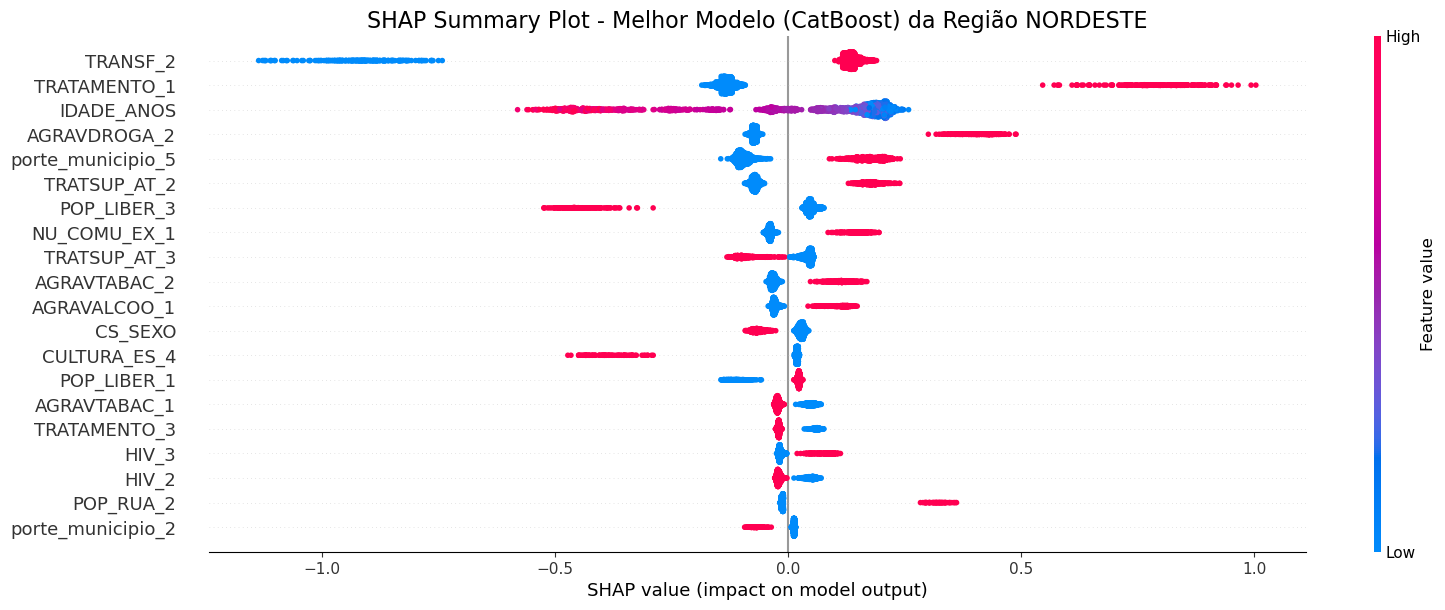


PROCESSANDO REGIÃO: NORTE
Buscando o melhor modelo no experimento 'ML_Modelagem_local_norte_2021_ohe'...
Melhor modelo encontrado: XGBoost com AUC de 0.7137 (Run ID: ed1b522dea3b4683b9dd5131be0e816b)


Modelo nativo (<class 'xgboost.sklearn.XGBClassifier'>) carregado com sucesso!
Carregando dados de teste para 'norte'...
Gerando gráfico SHAP...


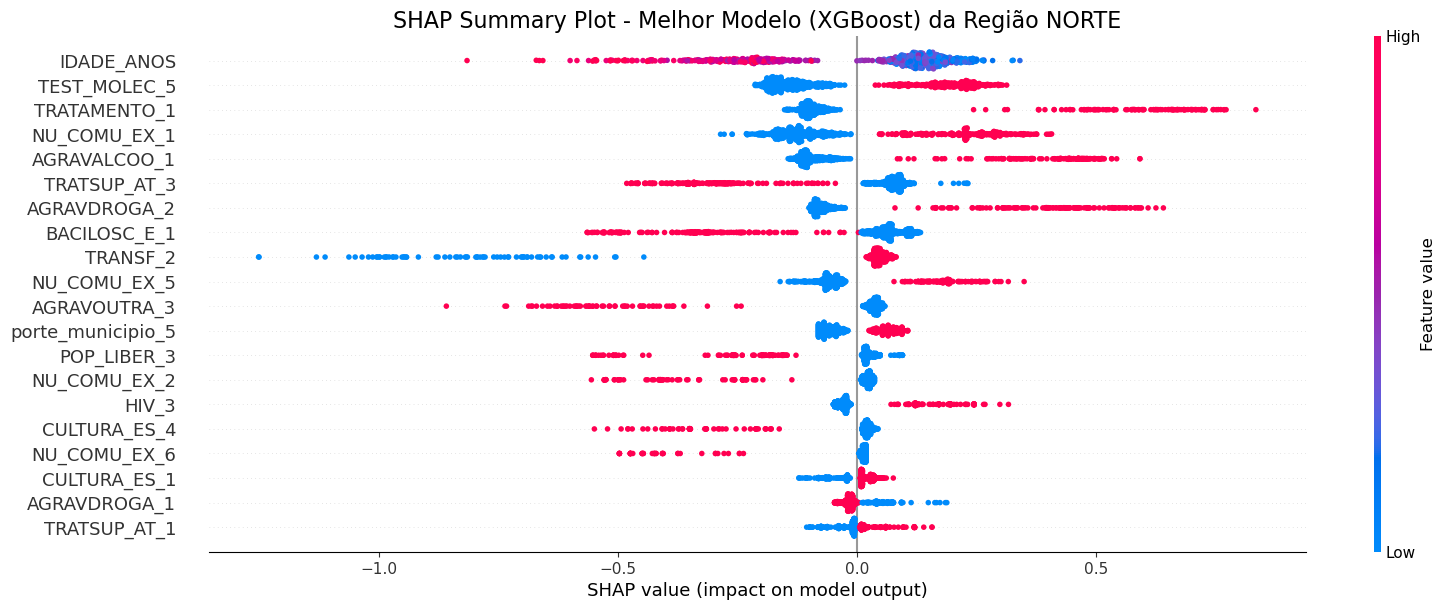


PROCESSANDO REGIÃO: CENTRO_OESTE
Buscando o melhor modelo no experimento 'ML_Modelagem_local_centro_oeste_2021_ohe'...
Melhor modelo encontrado: CatBoost com AUC de 0.7383 (Run ID: 38c9ee5b13b245a484040332f64df320)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'centro_oeste'...
Gerando gráfico SHAP...


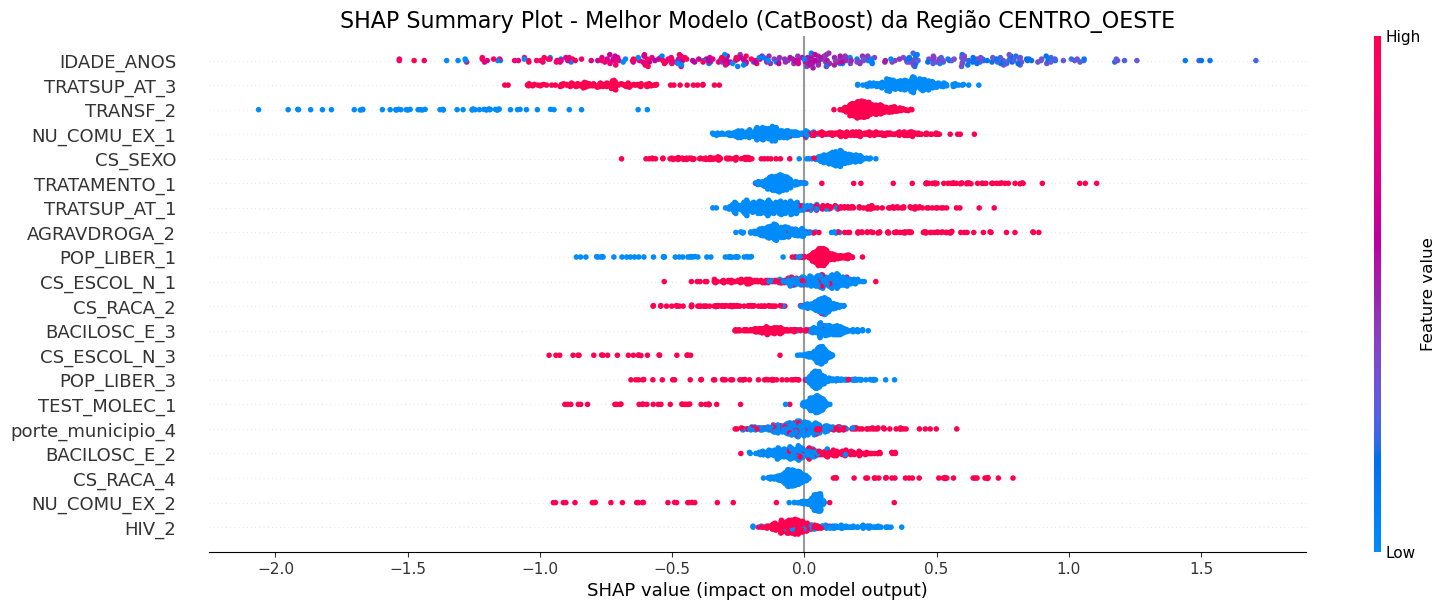


PROCESSANDO REGIÃO: SUDESTE
Buscando o melhor modelo no experimento 'ML_Modelagem_local_sudeste_2021_ohe'...
Melhor modelo encontrado: CatBoost com AUC de 0.8136 (Run ID: 7ade45eb80b64f8989ef31c7e9ed7896)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'sudeste'...
Gerando gráfico SHAP...


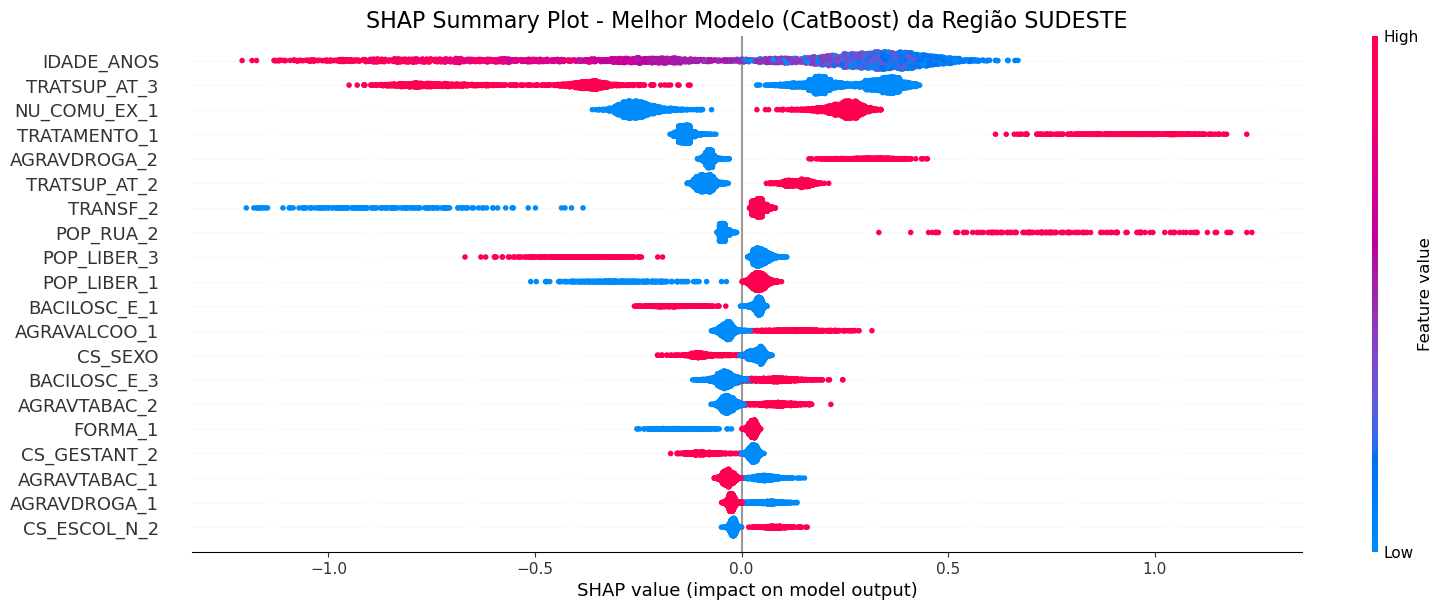


PROCESSANDO REGIÃO: SUL
Buscando o melhor modelo no experimento 'ML_Modelagem_local_sul_2021_ohe'...
Melhor modelo encontrado: XGBoost com AUC de 0.7971 (Run ID: d9571e9618b5403a8a4cd03d714061a5)


Modelo nativo (<class 'xgboost.sklearn.XGBClassifier'>) carregado com sucesso!
Carregando dados de teste para 'sul'...
Gerando gráfico SHAP...


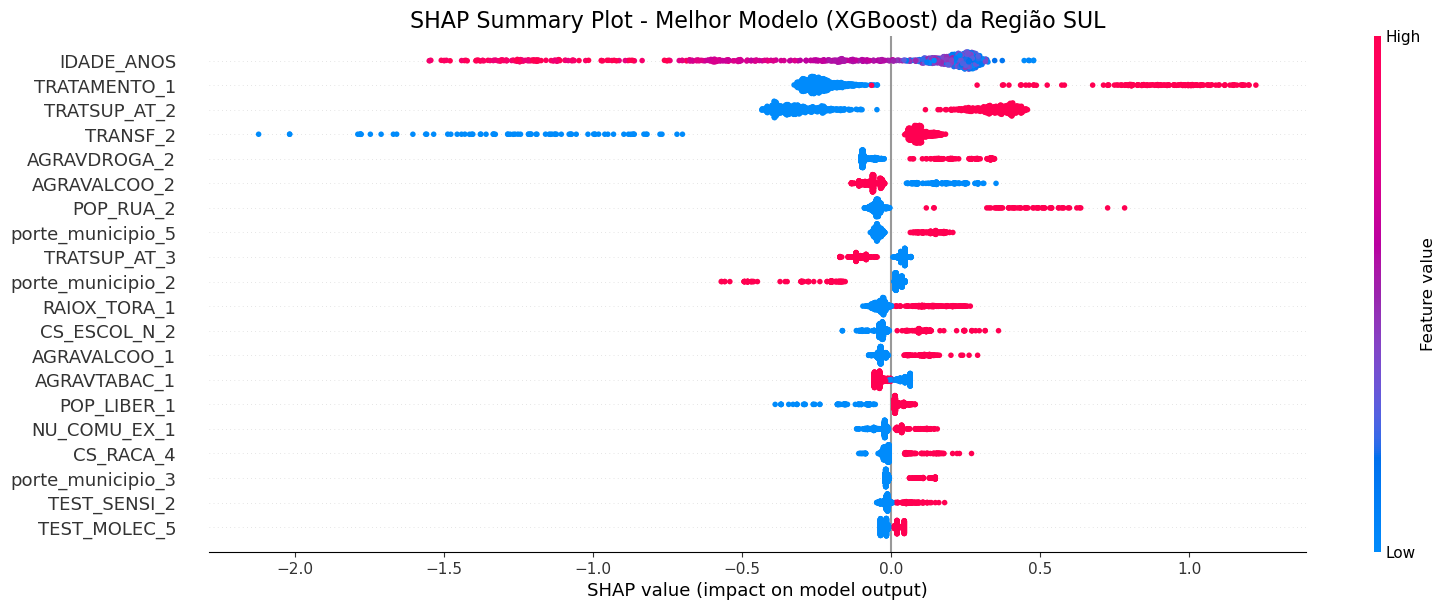


Análise SHAP para todas as regiões foi concluída.


In [21]:
# --- ETAPA 2: Loop principal para processar cada região ---

# O loop vai iterar sobre cada nome de região encontrado
for regiao in regioes:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO: {regiao.upper()}")
    print(f"{'='*70}")
    
    # Bloco try/except para lidar com possíveis erros (ex: região sem dados ou sem execuções)
    try:
        # 1. Definindo o experimento dinamicamente para a região atual
        nome_do_experimento = f"ML_Modelagem_local_{regiao}_2021_ohe"

        # 2. Buscando as execuções e encontrando a melhor (com base no maior AUC)
        print(f"Buscando o melhor modelo no experimento '{nome_do_experimento}'...")
        runs_df = mlflow.search_runs(experiment_names=[nome_do_experimento], order_by=["metrics.AUC DESC"])
        
        # Verifica se o experimento tem alguma execução (run)
        if runs_df.empty:
            print(f"AVISO: Nenhum modelo encontrado para a região '{regiao}'. Pulando para a próxima.")
            continue # Pula para a próxima iteração do loop
            
        best_run = runs_df.iloc[0]

        # 3. Extraindo as informações da melhor execução
        best_run_id = best_run.run_id
        model_name = best_run["tags.modelo"]
        model_auc = best_run["metrics.AUC"]
        
        print(f"Melhor modelo encontrado: {model_name} com AUC de {model_auc:.4f} (Run ID: {best_run_id})")

        # 4. Construindo a URI e carregando o modelo no seu "sabor" nativo
        model_uri = f"runs:/{best_run_id}/{model_name}"
        
        flavor_module = getattr(mlflow, model_name.lower())
        best_model_native = flavor_module.load_model(model_uri)
        print(f"Modelo nativo ({type(best_model_native)}) carregado com sucesso!")

        # 5. Carregando os dados de teste correspondentes à região atual
        print(f"Carregando dados de teste para '{regiao}'...")
        X_test_regiao = dados[f'X_test_{regiao}']

        # 6. Gerando SHAP com título dinâmico
        print("Gerando gráfico SHAP...")
        explainer = shap.TreeExplainer(best_model_native)
        shap_values = explainer.shap_values(X_test_regiao)
        
        # Título que será usado no gráfico
        titulo_grafico = f"SHAP Summary Plot - Melhor Modelo ({model_name}) da Região {regiao.upper()}"
        
        # Geramos o plot com show=False para poder adicionar o título antes de exibir
        shap.summary_plot(shap_values, X_test_regiao, show=False, plot_size=(16, 6))
        
        # Adicionamos o título customizado usando matplotlib
        plt.title(titulo_grafico, size=16)
        
        # Exibimos o gráfico final
        plt.show()

    except KeyError:
        # Erro caso não encontre os dados de teste no dicionário 'dados'
        print(f"ERRO: Não foram encontrados os dados de teste 'X_test_{regiao}' no dicionário 'dados'.")
    except Exception as e:
        # Pega qualquer outro erro que possa acontecer no processo
        print(f"Ocorreu um erro inesperado ao processar a região '{regiao}': {e}")

print(f"\n{'='*70}")
print("Análise SHAP para todas as regiões foi concluída.")
print(f"{'='*70}")